In [1]:
!pip install transformers trl peft bitsandbytes datasets evaluate rouge-score nltk sentencepiece


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.5 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=981b7110b48b1f5232a1e6415fc5cc905fc9f89cbd0ba539bf0cbb988bd5385d
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


In [2]:
!pip install huggingface_hub


In [5]:
import pandas as pd

news_df = pd.read_excel('Dataset.xlsx')[['content', 'title']]
news_df

,content,title
0,شرح ادعا: یک کاربر شبکه اجتماعی ایکس به نقل از...,طبق قانون جدید، افرادی که تا چهل سالگی ازدواج ...
1,شرح ادعا: خبرگزاری تابناک در گزارشی مدعی شده ا...,کیم جونگ اون با پاسپورت جعلی به ژاپن رفته است
2,شرح ادعا اکانت «ویکی تجربه» در شبکه اجتماعی ای...,اعمال محدودیت سنی در آگهی‌های استخدامی در اروپ...
3,شرح ادعا: یک کاربر شبکه اجتماعی اینستاگرام در ...,سوخت‌رسان انگلیسی در قطر، جنگنده‌های اسرائیلی ...
4,شرح ادعا: یک کاربر شبکه اجتماعی ایکس در پستی م...,ترور نافرجام خالد مشعل در 1997 منجر به تضعیف د...
...,...,...
1155,بنا بر یک ادعا که در توییتر و سایر رسانه‌های ا...,مهرعلی‌زاده در انتخابات مجلس سال ٩٨ رد صلاحیت ...
1156,با بررسی‌های صورت گرفته، دانشگاه آکسفورد تا به...,بر اساس رتبه‌بندی دانشگاه آکسفورد، ایران در رت...
1157,ایران‌اینترنشنال در پستی مدعی شده بوده که یک م...,نایب رئیس فاوا اتاق بازرگانی: بخش خصوصی نگران ...
1158,علی لاریحانی در کلاب‌هاوس مدعی شده بود که در م...,وهاب‌زاده: ادعای لاریجانی نادرست است؛ در آن زم...


In [ ]:
news_df['content_len'] = news_df['content'].apply(len)
news_df['title_len'] = news_df['title'].apply(len)

In [ ]:
news_df['content_len'].describe()

,content_len
count,1160.000000
mean,1552.722414
std,2233.553061
min,56.000000
25%,670.000000
50%,995.000000
75%,1669.750000
max,32767.000000


In [ ]:
news_df['title_len'].describe()


,title_len
count,1160.000000
mean,75.434483
std,28.659391
min,19.000000
25%,57.000000
50%,71.000000
75%,90.000000
max,338.000000


# prompt eng

In [5]:

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)
model_id = "mistralai/Mistral-7B-Instruct-v0.3"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=quantization_config,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

device = model.device

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
from sklearn.model_selection import train_test_split
import pandas as pd

train_df, test_df = train_test_split(news_df, test_size=0.2, random_state=42)

print(f"Train: {len(train_df)}, Test: {len(test_df)}")


Train: 928, Test: 232


In [7]:
from datasets import Dataset

test_dataset = Dataset.from_pandas(test_df)

print(f"Original size: {len(test_dataset)}")

test_dataset = test_dataset.shuffle(seed=42).select(range(min(50, len(test_dataset))))

print(f"Sampled size: {len(test_dataset)}")


Original size: 232
Sampled size: 50


In [8]:
print(test_dataset[1]['title'])

خبر مربوط به احتکار آب معدنی جعل و به جای آن خبر احتکار واکسن شایعه شد.


In [9]:
print(test_dataset[0]['title'])


ایران رتبه سوم بیشترین تعطیلی (بدون لحاظ آخر هفته) در جهان است


In [10]:
print(test_dataset[2]['title'])


نگه‌داری و استفاده از استارلینک در ایران غیرقانونی نیست


In [11]:
print(test_dataset[3]['title'])


شهر سانفرانسیسکو به‌دلیل سفر رئیس‌جمهور چین، با هزینه ۵۳ میلیون دلار بازسازی شد


In [12]:
from transformers import pipeline
import torch
import random

pipe = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)


`torch_dtype` is deprecated! Use `dtype` instead!
Device set to use cuda:0


In [13]:
import pandas as pd

fewshots = train_df.sample(n=2, random_state=42)[["content", "title"]].reset_index(drop=True)
fewshots


,content,title
0,خلاصه بررسی طبق برنامه تحصیلی ارائه شده برای گ...,سعید حدادیان استاد دانشگاه تهران شد
1,یک کاربر توییتر نوشته است که مشایی و بقایی در ...,مشایی و بقایی در زمان ریاست رئیسی بر قوه قضایی...


In [21]:

def generate_title_zero_shot(content):
    messages = [
        {"role": "user", "content": f"Read the following Persian news article and write a concise Persian news title.\n\n{content}"}
    ]
    prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    # print(f'promt: \n {prompt}')
    output = pipe(prompt, max_new_tokens=1000, do_sample=False)
    return output[0]["generated_text"].strip()

def generate_title_chain_of_thought(content):
    messages = [
        {
            "role": "user",
            "content": (
                "Read the following Persian news article carefully.\n"
                "Think through the key ideas **step by step in Persian** (do not translate or reason in English).\n"
                "Then, at the end, generate a **concise Persian news title** that best captures the main point.\n\n"
                f"{content}"
            ),
        }
    ]

    prompt = pipe.tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

    output = pipe(prompt, max_new_tokens=2000)
    return output[0]["generated_text"].strip()


def generate_title_few_shot(content, fewshots):
    """Few-shot: includes clear instruction + 2 examples"""
    examples = []
    instruction = "Read the following Persian news article and write a concise Persian news title."

    for _, row in fewshots.iterrows():
        examples.append(
            {"role": "user", "content": f"{instruction}\n\nArticle:\n{row['content']}\n\nTitle:"}
        )
        examples.append(
            {"role": "assistant", "content": row['title']}
        )

    examples.append(
        {"role": "user", "content": f"{instruction}\n\nArticle:\n{content}\n\nTitle:"}
    )

    prompt = pipe.tokenizer.apply_chat_template(examples, tokenize=False, add_generation_prompt=True)
    output = pipe(prompt, max_new_tokens=2000)
    return output[0]["generated_text"].strip()




In [22]:
import re

def clean_response(text):
    if not isinstance(text, str):
        return ""
    # Find last [/INST] and take everything after it
    parts = text.rsplit("[/INST]", 1)
    return parts[-1].strip() if len(parts) > 1 else text.strip()

results = []

indices = [0, 1, 2, 3]

for i in indices:
    row = test_dataset[i]

    zero_shot = generate_title_zero_shot(row['content'])
    cot = generate_title_chain_of_thought(row['content'])
    few_shot = generate_title_few_shot(row['content'], fewshots)

    zero_shot_clean = clean_response(zero_shot)
    cot_clean = clean_response(cot)
    few_shot_clean = clean_response(few_shot)

    results.append({
        "index": i,
        "reference": row['title'],
        "zero_shot": zero_shot_clean,
        "chain_of_thought": cot_clean,
        "few_shot": few_shot_clean
    })


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [23]:
for res in results:
    print(f"\n=== SAMPLE {res['index']} ===")
    print(f"Reference: {res['reference']}")
    print(f"Zero-shot: {res['zero_shot']}")
    print(f"Chain-of-thought: {res['chain_of_thought']}")
    print(f"Few-shot: {res['few_shot']}")



=== SAMPLE 0 ===
Reference: ایران رتبه سوم بیشترین تعطیلی (بدون لحاظ آخر هفته) در جهان است
Zero-shot: "ایران سومین کشور جهان با 26 روز تعطیل در سال است" نیز ممکن است در صورت توضیح کامل و بررسی به روز و با توجه به وجود تعطیلات روزهای آخر هفته و تعطیلات مناسبتی در ایران و در بعضی کشورهای غربی صحیح باشد، اما باید به این نکته توجه داشت که در کشورهای اروپایی، شنبه و یکشنبه به صورت کامل و رسمی تعطیل است و در ایران ممکن است پنجشنبه نیز روز کاری محسوب شود.
Chain-of-thought: 1. اعلام شرح در صفحه ایکس: خبرگزاری عربی «أمد للدراسات السياسية» در یک مقاله استاتیک اطلاع داده که ایران با داشتن ۲۶ روز تعطیل در سال، سومین کشور در جهان با بیشترین تعطیلی را در بین تعداد روزهای سال دارد.

2. نتیجه بررسی بر اساس اطلاعات بدست آمده از وبسایت بررسی جمعیت‌های جهان و بست دیپلمات: نپال و میانمار، با داشتن ۳۹ و ۳۲ روز تعطیل در سال به ترتیه در جایگاه‌های اول و دوم قرار دارند.

3. در کشورهای اروپایی، شنبه و یکشنبه به صورت کامل و رسمی تعطیل است، اما در ایران ممکن است که پنجشنبه نیز روز کاری محسوب شود.

4. بسیاری از 

In [16]:
import pandas as pd

data = [
    {
        "Index": 0,
        "Reference": "ایران رتبه سوم بیشترین تعطیلی (بدون لحاظ آخر هفته) در جهان است",
        "Few-shot": "عربی ادعا ایران سومین کشور جهانی با بیشترین روزهای تعطیل در سال است",
    },
    {
        "Index": 1,
        "Reference": "خبر مربوط به احتکار آب معدنی جعل و به جای آن خبر احتکار واکسن شایعه شد.",
        "Few-shot": "احتکار آب معدنی در سیستان و بلوچستان را با فتوشاپ به واکسن تغییر داده یا می شود",
    },
    {
        "Index": 2,
        "Reference": "نگه‌داری و استفاده از استارلینک در ایران غیرقانونی نیست",
        "Few-shot": "استفاده از استارلینک در ایران غیرقانونی نیست و مجازات در پی ندارد.",
    },
    {
        "Index": 3,
        "Reference": "شهر سانفرانسیسکو به‌دلیل سفر رئیس‌جمهور چین، با هزینه ۵۳ میلیون دلار بازسازی شد",
        "Few-shot": "مقامات شهر سانفرانسیسکو نظافت کرده و جمع‌آوری بی‌خانمان برای برگزاری نشست سازمان همکاری آسیا-پاسیفیک اقدام کرده‌اند",
    },
]

df = pd.DataFrame(data)


df


,Index,Reference,Few-shot
0,0,ایران رتبه سوم بیشترین تعطیلی (بدون لحاظ آخر هفته) در جهان است,عربی ادعا ایران سومین کشور جهانی با بیشترین روزهای تعطیل در سال است
1,1,خبر مربوط به احتکار آب معدنی جعل و به جای آن خبر احتکار واکسن شایعه شد.,احتکار آب معدنی در سیستان و بلوچستان را با فتوشاپ به واکسن تغییر داده یا می شود
2,2,نگه‌داری و استفاده از استارلینک در ایران غیرقانونی نیست,استفاده از استارلینک در ایران غیرقانونی نیست و مجازات در پی ندارد.
3,3,شهر سانفرانسیسکو به‌دلیل سفر رئیس‌جمهور چین، با هزینه ۵۳ میلیون دلار بازسازی شد,مقامات شهر سانفرانسیسکو نظافت کرده و جمع‌آوری بی‌خانمان برای برگزاری نشست سازمان همکاری آسیا-پاسیفیک اقدام کرده‌اند


In [5]:
import pandas as pd

data = [
    {
        "ID": 0,
        "Reference": "ایران رتبه سوم بیشترین تعطیلی (بدون لحاظ آخر هفته) در جهان است",
        "Zero-shot": "ایران سومین کشور جهان با ۲۶ روز تعطیل در سال است نیز ممکن است در صورت توضیح کامل و بررسی به روز و با توجه به وجود تعطیلات روزهای آخر هفته و تعطیلات مناسبتی در ایران و در بعضی کشورهای غربی صحیح باشد، اما باید به این نکته توجه داشت که در کشورهای اروپایی، شنبه و یکشنبه به صورت کامل و رسمی تعطیل است و در ایران ممکن است پنجشنبه نیز روز کاری محسوب شود."
    },
    {
        "ID": 1,
        "Reference": "خبر مربوط به احتکار آب معدنی جعل و به جای آن خبر احتکار واکسن شایعه شد.",
        "Zero-shot": "نیکی ملکی: شیطنت رسانه‌ایی با فتوشاپ به احتکار آب معدنی را به واکسن تبدیل کرده‌اند"
    },
    {
        "ID": 2,
        "Reference": "نگه‌داری و استفاده از استارلینک در ایران غیرقانونی نیست",
        "Zero-shot": "استفاده از استارلینک در ایران غیرقانونی نیست و جرم‌انگاری نشده"
    },
    {
        "ID": 3,
        "Reference": "شهر سانفرانسیسکو به‌دلیل سفر رئیس‌جمهور چین، با هزینه ۵۳ میلیون دلار بازسازی شد",
        "Zero-shot": "سفر رییس جمهور چین به آمریکا: ادعای کاربر نادرست در مورد نظافت و بازسازی شهر سانفرانسیسکو در زمان برگزاری نشست سران سازمان همکاری آسیا-پاسیفیک"
    },
]

df = pd.DataFrame(data)

df


,ID,Reference,Zero-shot
0,0,ایران رتبه سوم بیشترین تعطیلی (بدون لحاظ آخر هفته) در جهان است,ایران سومین کشور جهان با ۲۶ روز تعطیل در سال است نیز ممکن است در صورت توضیح کامل و بررسی به روز و با توجه به وجود تعطیلات روزهای آخر هفته و تعطیلات مناسبتی در ایران و در بعضی کشورهای غربی صحیح باشد، اما باید به این نکته توجه داشت که در کشورهای اروپایی، شنبه و یکشنبه به صورت کامل و رسمی تعطیل است و در ایران ممکن است پنجشنبه نیز روز کاری محسوب شود.
1,1,خبر مربوط به احتکار آب معدنی جعل و به جای آن خبر احتکار واکسن شایعه شد.,نیکی ملکی: شیطنت رسانه‌ایی با فتوشاپ به احتکار آب معدنی را به واکسن تبدیل کرده‌اند
2,2,نگه‌داری و استفاده از استارلینک در ایران غیرقانونی نیست,استفاده از استارلینک در ایران غیرقانونی نیست و جرم‌انگاری نشده
3,3,شهر سانفرانسیسکو به‌دلیل سفر رئیس‌جمهور چین، با هزینه ۵۳ میلیون دلار بازسازی شد,سفر رییس جمهور چین به آمریکا: ادعای کاربر نادرست در مورد نظافت و بازسازی شهر سانفرانسیسکو در زمان برگزاری نشست سران سازمان همکاری آسیا-پاسیفیک


In [9]:

data = [
    {
        "ID": 0,
        "Reference": "ایران رتبه سوم بیشترین تعطیلی (بدون لحاظ آخر هفته) در جهان است",
        "Model_Output": "ادعای خبرگزاری عربی « أمد للدراسات السياسية » محتوای پیاده نشده، به اعلان بازدید مردم به مناسبت‌های تقویمی تعطیلی در ایران و به تعریف هفتگی تعطیلی ایران با در نظر گرفتن بازدید مردم به مناسبت‌های تقویمی ندارد"
    },
    {
        "ID": 1,
        "Reference": "خبر مربوط به احتکار آب معدنی جعل و به جای آن خبر احتکار واکسن شایعه شد.",
        "Model_Output": "با فعالیت فتوشاپ رسانه‌ها، برخی از احتکارهای رسانه در مورد احتکار آب معدنی در سیستان و بلوچستان برخی از مقامات را به احترام نمی‌برد."
    },
    {
        "ID": 2,
        "Reference": "نگه‌داری و استفاده از استارلینک در ایران غیرقانونی نیست",
        "Model_Output": "نگهداری و استفاده از استارلینک در ایران غیرقانونی نیست و جرم‌انگاری نشده است"
    },
    {
        "ID": 3,
        "Reference": "شهر سانفرانسیسکو به‌دلیل سفر رئیس‌جمهور چین، با هزینه ۵۳ میلیون دلار بازسازی شد",
        "Model_Output": "بازدید رییس جمهور چین به سانفرانسیسکو: مقامات از نظافت و جمع‌آوری بی‌خانمان به صورت اقتصادی بر اساس نشست سران به دلیل میزبانی اقدام کردند"
    }
]

df = pd.DataFrame(data)


df


,ID,Reference,Model_Output
0,0,ایران رتبه سوم بیشترین تعطیلی (بدون لحاظ آخر هفته) در جهان است,ادعای خبرگزاری عربی « أمد للدراسات السياسية » محتوای پیاده نشده، به اعلان بازدید مردم به مناسبت‌های تقویمی تعطیلی در ایران و به تعریف هفتگی تعطیلی ایران با در نظر گرفتن بازدید مردم به مناسبت‌های تقویمی ندارد
1,1,خبر مربوط به احتکار آب معدنی جعل و به جای آن خبر احتکار واکسن شایعه شد.,با فعالیت فتوشاپ رسانه‌ها، برخی از احتکارهای رسانه در مورد احتکار آب معدنی در سیستان و بلوچستان برخی از مقامات را به احترام نمی‌برد.
2,2,نگه‌داری و استفاده از استارلینک در ایران غیرقانونی نیست,نگهداری و استفاده از استارلینک در ایران غیرقانونی نیست و جرم‌انگاری نشده است
3,3,شهر سانفرانسیسکو به‌دلیل سفر رئیس‌جمهور چین، با هزینه ۵۳ میلیون دلار بازسازی شد,بازدید رییس جمهور چین به سانفرانسیسکو: مقامات از نظافت و جمع‌آوری بی‌خانمان به صورت اقتصادی بر اساس نشست سران به دلیل میزبانی اقدام کردند


In [13]:
thought = """
 1. شخصیتی نامیده شده به نام نیکی ملکی، مدیر روابط عمومی ستاد فرمان امام، در توییتر مدعی شد
   - با شاخصه "با جعل صفحه خبری در خبرگزاری صداو‌سیما در ارتباط با احتکار آب معدنی، مدعی احتکار واکسن برکت شده اند."

2. این مدعی ایمنی در مرکز سیستان و بلوچستان را به تاریخ ۱۹ تیر ۱۴۰۰، خبرگزاری صدا‌و‌سیما در جهت احتکار آب معدنی در سیستان و بلوچستان به گزارش را ارسال کرده است.

3. این خبر، که در فضای مجازی در حال چرخش است مربوط به احتکار آب معدنی در سیستان و بلوچستان است که در تاریخ ۶ اسفند ۱۳۹۹، ساعت  ۲۲:۳۹ با "تیتر احتکار ۲۸ هزار بطری آب معدنی احتکاری در بازرسی از یک انبار " منتشر شده است.

4. برخی رسانه‌های فعال در شبکه های اجتماعی، با فعالیت های دستکاری و فتوشاپ برابر واکسن ، احتکار واکسن را به احتکار آب معدنی تغییر داده اند.

در نتیجه به درستی، می توان گفت:

" با فعالیت بازرسی رسانه‌ها در شبکه های اجتماعی، برخی از مقامات بر احتکار آب معدنی در سیستان و بلوچستان احترام نمی کنند"

یا

" با فعالیت فتوشاپ رسانه‌ها، برخی از احتکار های رسانه در مورد احتکار آب معدنی در سیستان و بلوچستان برخی از مقامات را به احترام نمی برد."
"""

In [14]:

data = [
    {
        "T": thought
    }
]

df = pd.DataFrame(data)


df


,T
0,"\n 1. شخصیتی نامیده شده به نام نیکی ملکی، مدیر روابط عمومی ستاد فرمان امام، در توییتر مدعی شد\n - با شاخصه ""با جعل صفحه خبری در خبرگزاری صداو‌سیما در ارتباط با احتکار آب معدنی، مدعی احتکار واکسن برکت شده اند.""\n\n2. این مدعی ایمنی در مرکز سیستان و بلوچستان را به تاریخ ۱۹ تیر ۱۴۰۰، خبرگزاری صدا‌و‌سیما در جهت احتکار آب معدنی در سیستان و بلوچستان به گزارش را ارسال کرده است.\n\n3. این خبر، که در فضای مجازی در حال چرخش است مربوط به احتکار آب معدنی در سیستان و بلوچستان است که در تاریخ ۶ اسفند ۱۳۹۹، ساعت ۲۲:۳۹ با ""تیتر احتکار ۲۸ هزار بطری آب معدنی احتکاری در بازرسی از یک انبار "" منتشر شده است.\n\n4. برخی رسانه‌های فعال در شبکه های اجتماعی، با فعالیت های دستکاری و فتوشاپ برابر واکسن ، احتکار واکسن را به احتکار آب معدنی تغییر داده اند.\n\nدر نتیجه به درستی، می توان گفت:\n\n"" با فعالیت بازرسی رسانه‌ها در شبکه های اجتماعی، برخی از مقامات بر احتکار آب معدنی در سیستان و بلوچستان احترام نمی کنند""\n\nیا\n\n"" با فعالیت فتوشاپ رسانه‌ها، برخی از احتکار های رسانه در مورد احتکار آب معدنی در سیستان و بلوچستان برخی از مقامات را به احترام نمی برد.""\n"


# Fine tune

## Mistral

### Train

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

train_df, test_df = train_test_split(news_df, test_size=0.2, random_state=42)

print(f"Train: {len(train_df)}, Test: {len(test_df)}")


Train: 928, Test: 232


In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

model_id = "mistralai/Mistral-7B-Instruct-v0.3"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [ ]:
from trl import apply_chat_template
from datasets import Dataset

def build_dataset(df):
    prompts, completions = [], []

    for _, row in df.iterrows():
        prompt = [
            {"role": "user", "content": f"Read the following Persian news article and write a concise Persian title:\n\n{row['content']}"}
        ]

        completion = [
            {"role": "assistant", "content": row["title"].strip()}
        ]

        prompts.append(prompt)
        completions.append(completion)

    dataset = Dataset.from_dict({"prompt": prompts, "completion": completions})
    return dataset


train_dataset = build_dataset(train_df)
test_dataset = build_dataset(test_df)

train_dataset = train_dataset.map(
    apply_chat_template,
    fn_kwargs={"tokenizer": tokenizer}
)

test_dataset = test_dataset.map(
    apply_chat_template,
    fn_kwargs={"tokenizer": tokenizer},
)


Map:   0%|          | 0/928 [00:00<?, ? examples/s]

Map:   0%|          | 0/232 [00:00<?, ? examples/s]

In [ ]:
train_dataset[0]

{'prompt': '<s>[INST] Read the following Persian news article and write a concise Persian title:\n\nشرح ادعا کاربری در شبکه اجتماعی ایکس ادعا کرد که کمیته بین المللی المپیک، فیلم افتتاحیه المپیک ۲۰۲۴ پاریس را از سایت رسمی خود حذف کرده\u200cاست. نتیجه بررسی بر اساس گزارش خبرگزاری\u200cهای businesstoday و dailymail ، کاربران اعلام کرده\u200cاند که در سایت رسمی و کانال یوتیوب با پیام در دسترس نبودن فیلم مواجه می\u200cشوند. همچنین، براساس بررسی\u200cهای امروز فکت\u200cیار، در سایت رسمی کمیته بین المللی المپیک، اجازه دسترسی به فیلم افتتاحیه المپیک ۲۰۲۴ پاریس داده نمی\u200cشود و همچنین در کانال یوتیوب کمیته بین\u200cالمللی المپیک، اثری از فیلم افتتاحیه المپیک ۲۰۲۴ پاریس نیست. بنابراین، ادعای کاربر در مورد حذف شدن فیلم افتتاحیه المپیک ۲۰۲۴ از سایت رسمی کمیته بین المللی المپیک درست ارزیابی می\u200cشود.[/INST]',
 'completion': ' کمیته بین\u200cالمللی المپیک فیلم افتتاحیه المپیک ۲۰۲۴ پاریس را از سایت و کانال یوتیوب خود حذف کرد</s>'}

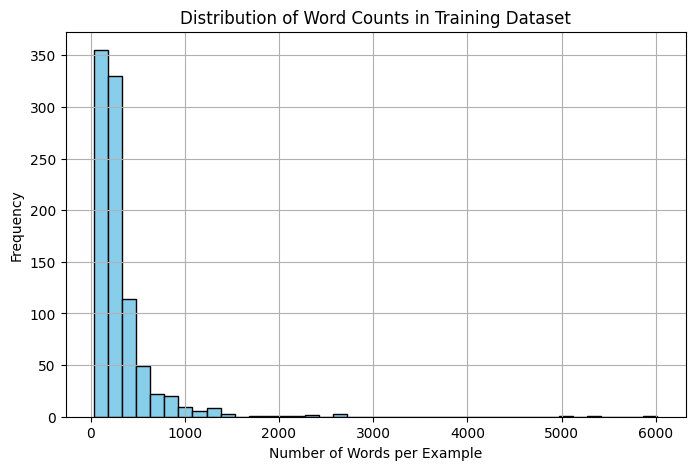

Mean: 325.0
Max: 6018
90th percentile: 596


In [ ]:
import matplotlib.pyplot as plt

word_counts = [
    len((ex["prompt"] + " " + ex["completion"]).split())
    for ex in train_dataset
]

plt.figure(figsize=(8, 5))
plt.hist(word_counts, bins=40, color='skyblue', edgecolor='black')
plt.title("Distribution of Word Counts in Training Dataset")
plt.xlabel("Number of Words per Example")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

print(f"Mean: {sum(word_counts)/len(word_counts):.1f}")
print(f"Max: {max(word_counts)}")
print(f"90th percentile: {sorted(word_counts)[int(0.9*len(word_counts))]}")


In [ ]:
train_dataset[0]

{'prompt': '<s>[INST] Read the following Persian news article and write a concise Persian title:\n\nشرح ادعا کاربری در شبکه اجتماعی ایکس ادعا کرد که کمیته بین المللی المپیک، فیلم افتتاحیه المپیک ۲۰۲۴ پاریس را از سایت رسمی خود حذف کرده\u200cاست. نتیجه بررسی بر اساس گزارش خبرگزاری\u200cهای businesstoday و dailymail ، کاربران اعلام کرده\u200cاند که در سایت رسمی و کانال یوتیوب با پیام در دسترس نبودن فیلم مواجه می\u200cشوند. همچنین، براساس بررسی\u200cهای امروز فکت\u200cیار، در سایت رسمی کمیته بین المللی المپیک، اجازه دسترسی به فیلم افتتاحیه المپیک ۲۰۲۴ پاریس داده نمی\u200cشود و همچنین در کانال یوتیوب کمیته بین\u200cالمللی المپیک، اثری از فیلم افتتاحیه المپیک ۲۰۲۴ پاریس نیست. بنابراین، ادعای کاربر در مورد حذف شدن فیلم افتتاحیه المپیک ۲۰۲۴ از سایت رسمی کمیته بین المللی المپیک درست ارزیابی می\u200cشود.[/INST]',
 'completion': ' کمیته بین\u200cالمللی المپیک فیلم افتتاحیه المپیک ۲۰۲۴ پاریس را از سایت و کانال یوتیوب خود حذف کرد</s>'}

In [20]:
import pandas as pd

data = [{
    "Prompt": "<s>[INST] Read the following Persian news article and write a concise Persian title:\n\nشرح ادعا کاربری در شبکه اجتماعی ایکس ادعا کرد که کمیته بین المللی المپیک، فیلم افتتاحیه المپیک ۲۰۲۴ پاریس را از سایت رسمی خود حذف کرده‌است. نتیجه بررسی بر اساس گزارش خبرگزاری‌های businesstoday و dailymail ، کاربران اعلام کرده‌اند که در سایت رسمی و کانال یوتیوب با پیام در دسترس نبودن فیلم مواجه می‌شوند. همچنین، براساس بررسی‌های امروز فکت‌یار، در سایت رسمی کمیته بین المللی المپیک، اجازه دسترسی به فیلم افتتاحیه المپیک ۲۰۲۴ پاریس داده نمی‌شود و همچنین در کانال یوتیوب کمیته بین‌المللی المپیک، اثری از فیلم افتتاحیه المپیک ۲۰۲۴ پاریس نیست. بنابراین، ادعای کاربر در مورد حذف شدن فیلم افتتاحیه المپیک ۲۰۲۴ از سایت رسمی کمیته بین المللی المپیک درست ارزیابی می‌شود.[/INST] کمیته بین‌المللی المپیک فیلم افتتاحیه المپیک ۲۰۲۴ پاریس را از سایت و کانال یوتیوب خود حذف کرد</s>"
}]

df = pd.DataFrame(data)

df


,Prompt
0,<s>[INST] Read the following Persian news article and write a concise Persian title:\n\nشرح ادعا کاربری در شبکه اجتماعی ایکس ادعا کرد که کمیته بین المللی المپیک، فیلم افتتاحیه المپیک ۲۰۲۴ پاریس را از سایت رسمی خود حذف کرده‌است. نتیجه بررسی بر اساس گزارش خبرگزاری‌های businesstoday و dailymail ، کاربران اعلام کرده‌اند که در سایت رسمی و کانال یوتیوب با پیام در دسترس نبودن فیلم مواجه می‌شوند. همچنین، براساس بررسی‌های امروز فکت‌یار، در سایت رسمی کمیته بین المللی المپیک، اجازه دسترسی به فیلم افتتاحیه المپیک ۲۰۲۴ پاریس داده نمی‌شود و همچنین در کانال یوتیوب کمیته بین‌المللی المپیک، اثری از فیلم افتتاحیه المپیک ۲۰۲۴ پاریس نیست. بنابراین، ادعای کاربر در مورد حذف شدن فیلم افتتاحیه المپیک ۲۰۲۴ از سایت رسمی کمیته بین المللی المپیک درست ارزیابی می‌شود.[/INST] کمیته بین‌المللی المپیک فیلم افتتاحیه المپیک ۲۰۲۴ پاریس را از سایت و کانال یوتیوب خود حذف کرد</s>


In [ ]:
from datasets import Dataset

print(f"Original size: {len(train_dataset)}")

# Sample 500 random examples
train_dataset = train_dataset.shuffle(seed=42).select(range(min(500, len(train_dataset))))

print(f"Sampled size: {len(train_dataset)}")


Original size: 928
Sampled size: 500


In [ ]:
from peft import LoraConfig

peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=["q_proj", "v_proj"],  # attention projection layers
    bias="none",
    task_type="CAUSAL_LM"
)

In [ ]:
from trl import SFTConfig

sft_config = SFTConfig(
    output_dir="./mistral-news-qlora",
    overwrite_output_dir=True,
      num_train_epochs=1,
      per_device_train_batch_size=4,
      gradient_accumulation_steps=8,
      learning_rate=1e-4,
      max_length=596,
    bf16=True,
    gradient_checkpointing=True,
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
    logging_steps=100,
    save_strategy="epoch",
    save_total_limit=2,
    push_to_hub=True,
    hub_model_id="HoseinPanahi/mistral-news-qlora",
    hub_private_repo=False,
    report_to=[],
)


In [ ]:
from trl import SFTTrainer, SFTConfig
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    processing_class=tokenizer,
    peft_config=peft_config,
    args=sft_config,
)


Adding EOS to train dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/232 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/232 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/232 [00:00<?, ? examples/s]

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
model.config.pad_token_id = tokenizer.pad_token_id
model.config.eos_token_id = tokenizer.eos_token_id
model.config.bos_token_id = tokenizer.bos_token_id

In [ ]:
trainer.train()


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


TrainOutput(global_step=16, training_loss=0.5531741380691528, metrics={'train_runtime': 5881.8073, 'train_samples_per_second': 0.085, 'train_steps_per_second': 0.003, 'total_flos': 1.2725578088448e+16, 'train_loss': 0.5531741380691528, 'entropy': 0.9889180326461792, 'num_tokens': 288020.0, 'mean_token_accuracy': 0.47440071535110473, 'epoch': 1.0})

### Test

In [6]:

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model_id = "HoseinPanahi/mistral-news-qlora"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=quantization_config,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

device = model.device

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

adapter_config.json:   0%|          | 0.00/868 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [7]:
import evaluate
from tqdm import tqdm
from transformers import pipeline

rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")
meteor = evaluate.load("meteor")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [8]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype="auto",
    device_map="auto",
    max_new_tokens=1000,
    do_sample=False,
)


`torch_dtype` is deprecated! Use `dtype` instead!
Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [9]:
from sklearn.model_selection import train_test_split
import pandas as pd

train_df, test_df = train_test_split(news_df, test_size=0.2, random_state=42)

print(f"Train: {len(train_df)}, Test: {len(test_df)}")


Train: 928, Test: 232


In [11]:
from trl import apply_chat_template
from datasets import Dataset

def build_dataset(df):
    prompts, completions = [], []

    for _, row in df.iterrows():
        prompt = [
            {"role": "user", "content": f"Read the following Persian news article and write a concise Persian title:\n\n{row['content']}"}
        ]

        completion = [
            {"role": "assistant", "content": row["title"].strip()}
        ]

        prompts.append(prompt)
        completions.append(completion)

    dataset = Dataset.from_dict({"prompt": prompts, "completion": completions})
    return dataset


test_dataset = build_dataset(test_df)


test_dataset = test_dataset.map(
    apply_chat_template,
    fn_kwargs={"tokenizer": tokenizer},
)


Map:   0%|          | 0/232 [00:00<?, ? examples/s]

In [12]:
from datasets import Dataset

print(f"Original size: {len(test_dataset)}")

test_dataset = test_dataset.shuffle(seed=42).select(range(min(50, len(test_dataset))))

print(f"Sampled size: {len(test_dataset)}")


Original size: 232
Sampled size: 50


In [13]:

preds, refs = [], []

for example in tqdm(test_dataset, desc="Evaluating"):
    prompt = example["prompt"]
    response = pipe(prompt)
    pred = response[0]["generated_text"].strip()
    preds.append(pred)
    ref = example["completion"].strip()
    refs.append(ref)



Evaluating: 100%|██████████| 50/50 [07:56<00:00,  9.54s/it]


In [14]:
preds[0][1000:]

'ورهای توسعه یافته، معمولا یک تعطیلات پاییزه و یا بهاره در مدارس و دانشگاه\u200cها وجود دارد و طول آن یک هفته\u200c است. شاید بنابر مناسبت\u200cهای تقویمی تعطیل، ایران میزان تعطیلی بالایی داشته باشد، اما این به معنای داشتن بیشترین روزهای تعطیل در سال نیست. بنابراین، ادعای خبرگزاری عربی « أمد للدراسات السياسية»، نیمه\u200cدرست ارزیابی می\u200cشود.[/INST] ایران سومین کشور جهان با بیشترین روزهای تعطیل در سال است'

In [15]:
import re

def extract_responses(preds):
    """
    Extract only the assistant's answer text after [/INST].
    """
    responses = []
    pattern = re.compile(r"\[/INST\](.*?)(?:</s>|$)", re.DOTALL)

    for text in preds:
        if not isinstance(text, str):
            responses.append("")  # skip invalid items
            continue

        match = pattern.search(text)
        if match:
            answer = match.group(1).strip()
        else:
            # if no [/INST], use the whole text as fallback
            answer = text.strip()
        responses.append(answer)

    return responses

clean_preds = extract_responses(preds)


In [16]:
import pandas as pd

results_df = pd.DataFrame({
    "reference": refs,
    "prediction": clean_preds
})


results_df.to_csv("mistral_evaluation_results.csv", index=False, encoding="utf-8-sig")


results_df.head()


,reference,prediction
0,ایران رتبه سوم بیشترین تعطیلی (بدون لحاظ آخر ه...,ایران سومین کشور جهان با بیشترین روزهای تعطیل ...
1,خبر مربوط به احتکار آب معدنی جعل و به جای آن خ...,احتکار آب معدنی در سیستان و بلوچستان با فتوشاپ...
2,نگه‌داری و استفاده از استارلینک در ایران غیرقا...,استفاده از استارلینک در ایران غیرقانونی نیست
3,شهر سانفرانسیسکو به‌دلیل سفر رئیس‌جمهور چین، ب...,سانفرانسیسکو: مقامات شهر برگزاری نشست سران ساز...
4,امارات سالیانه ۲.۵ میلیون لیتر آب آشامیدنی از ...,امارات موفق به تولید 2.5 میلیون لیتر آب آشامید...


In [17]:
clean_preds[0]

'ایران سومین کشور جهان با بیشترین روزهای تعطیل در سال است'

In [18]:
refs[0]

'ایران رتبه سوم بیشترین تعطیلی (بدون لحاظ آخر هفته) در جهان است</s>'

In [ ]:
clean_preds[1]

'احتکار آب معدنی در سیستان و بلوچستان با فتوشاپ به واکسن تبدیل شده است'

In [ ]:
refs[1]

'خبر مربوط به احتکار آب معدنی جعل و به جای آن خبر احتکار واکسن شایعه شد.</s>'

In [19]:

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 300)
pd.set_option('display.colheader_justify', 'center')


In [20]:
results_df.head()

,reference,prediction
0,ایران رتبه سوم بیشترین تعطیلی (بدون لحاظ آخر هفته) در جهان است</s>,ایران سومین کشور جهان با بیشترین روزهای تعطیل در سال است
1,خبر مربوط به احتکار آب معدنی جعل و به جای آن خبر احتکار واکسن شایعه شد.</s>,احتکار آب معدنی در سیستان و بلوچستان با فتوشاپ به واکسن تبدیل شده است
2,نگه‌داری و استفاده از استارلینک در ایران غیرقانونی نیست</s>,استفاده از استارلینک در ایران غیرقانونی نیست
3,شهر سانفرانسیسکو به‌دلیل سفر رئیس‌جمهور چین، با هزینه ۵۳ میلیون دلار بازسازی شد</s>,سانفرانسیسکو: مقامات شهر برگزاری نشست سران سازمان همکاری آسیا-پاسیفیک اقدام به نظافت شهر و جمع‌آوری بی‌خانمان‌ها از سطح این شهر کرده‌اند
4,امارات سالیانه ۲.۵ میلیون لیتر آب آشامیدنی از هوا تولید می‌کند</s>,امارات موفق به تولید 2.5 میلیون لیتر آب آشامیدنی از رطوبت هوا در سال بوده است


In [ ]:

rouge_result = rouge.compute(predictions=clean_preds, references=refs)
bleu_result = bleu.compute(predictions=clean_preds, references=refs)
meteor_result = meteor.compute(predictions=clean_preds, references=refs)

print("Evaluation Results")
print(f"ROUGE-L:  {rouge_result['rougeL']:.4f}")
print(f"BLEU:     {bleu_result['bleu']:.4f}")
print(f"METEOR:   {meteor_result['meteor']:.4f}")

🟢 Evaluation Results
ROUGE-L:  0.0133
BLEU:     0.1475
METEOR:   0.3002


## qwen

### Train

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

train_df, test_df = train_test_split(news_df, test_size=0.2, random_state=42)

print(f"Train: {len(train_df)}, Test: {len(test_df)}")


Train: 928, Test: 232


In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

model_id = "Qwen/Qwen2.5-7B-Instruct-1M"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
from trl import apply_chat_template
from datasets import Dataset

def build_dataset(df):
    prompts, completions = [], []

    for _, row in df.iterrows():
        prompt = [
            {"role": "user", "content": f"Read the following Persian news article and write a concise Persian title:\n\n{row['content']}"}
        ]

        completion = [
            {"role": "assistant", "content": row["title"].strip()}
        ]

        prompts.append(prompt)
        completions.append(completion)

    dataset = Dataset.from_dict({"prompt": prompts, "completion": completions})
    return dataset


train_dataset = build_dataset(train_df)
test_dataset = build_dataset(test_df)

train_dataset = train_dataset.map(
    apply_chat_template,
    fn_kwargs={"tokenizer": tokenizer}
)

test_dataset = test_dataset.map(
    apply_chat_template,
    fn_kwargs={"tokenizer": tokenizer},
)


Map:   0%|          | 0/928 [00:00<?, ? examples/s]

Map:   0%|          | 0/232 [00:00<?, ? examples/s]

In [ ]:
train_dataset[0]

{'prompt': '<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\nRead the following Persian news article and write a concise Persian title:\n\nشرح ادعا کاربری در شبکه اجتماعی ایکس ادعا کرد که کمیته بین المللی المپیک، فیلم افتتاحیه المپیک ۲۰۲۴ پاریس را از سایت رسمی خود حذف کرده\u200cاست. نتیجه بررسی بر اساس گزارش خبرگزاری\u200cهای businesstoday و dailymail ، کاربران اعلام کرده\u200cاند که در سایت رسمی و کانال یوتیوب با پیام در دسترس نبودن فیلم مواجه می\u200cشوند. همچنین، براساس بررسی\u200cهای امروز فکت\u200cیار، در سایت رسمی کمیته بین المللی المپیک، اجازه دسترسی به فیلم افتتاحیه المپیک ۲۰۲۴ پاریس داده نمی\u200cشود و همچنین در کانال یوتیوب کمیته بین\u200cالمللی المپیک، اثری از فیلم افتتاحیه المپیک ۲۰۲۴ پاریس نیست. بنابراین، ادعای کاربر در مورد حذف شدن فیلم افتتاحیه المپیک ۲۰۲۴ از سایت رسمی کمیته بین المللی المپیک درست ارزیابی می\u200cشود.<|im_end|>\n<|im_start|>assistant\n',
 'completion': 'کمیته بین\u200cالمللی المپیک فیلم افتتاحیه المپیک ۲۰۲۴ پاریس را از سایت و

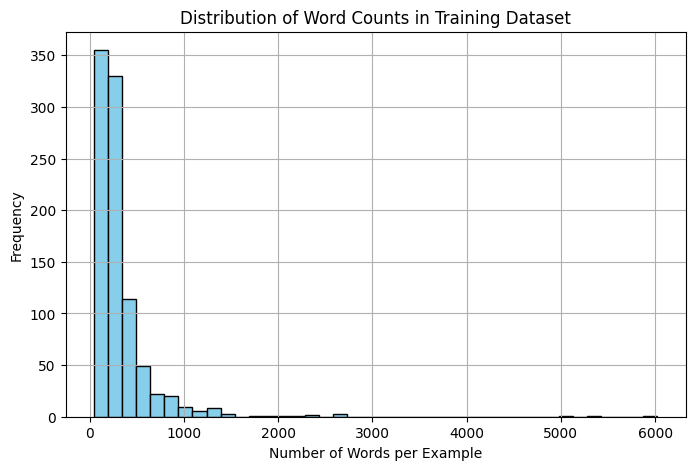

Mean: 332.0
Max: 6025
90th percentile: 603


In [ ]:
import matplotlib.pyplot as plt

word_counts = [
    len((ex["prompt"] + " " + ex["completion"]).split())
    for ex in train_dataset
]

plt.figure(figsize=(8, 5))
plt.hist(word_counts, bins=40, color='skyblue', edgecolor='black')
plt.title("Distribution of Word Counts in Training Dataset")
plt.xlabel("Number of Words per Example")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

print(f"Mean: {sum(word_counts)/len(word_counts):.1f}")
print(f"Max: {max(word_counts)}")
print(f"90th percentile: {sorted(word_counts)[int(0.9*len(word_counts))]}")


In [ ]:
train_dataset[0]

{'prompt': '<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\nRead the following Persian news article and write a concise Persian title:\n\nشرح ادعا کاربری در شبکه اجتماعی ایکس ادعا کرد که کمیته بین المللی المپیک، فیلم افتتاحیه المپیک ۲۰۲۴ پاریس را از سایت رسمی خود حذف کرده\u200cاست. نتیجه بررسی بر اساس گزارش خبرگزاری\u200cهای businesstoday و dailymail ، کاربران اعلام کرده\u200cاند که در سایت رسمی و کانال یوتیوب با پیام در دسترس نبودن فیلم مواجه می\u200cشوند. همچنین، براساس بررسی\u200cهای امروز فکت\u200cیار، در سایت رسمی کمیته بین المللی المپیک، اجازه دسترسی به فیلم افتتاحیه المپیک ۲۰۲۴ پاریس داده نمی\u200cشود و همچنین در کانال یوتیوب کمیته بین\u200cالمللی المپیک، اثری از فیلم افتتاحیه المپیک ۲۰۲۴ پاریس نیست. بنابراین، ادعای کاربر در مورد حذف شدن فیلم افتتاحیه المپیک ۲۰۲۴ از سایت رسمی کمیته بین المللی المپیک درست ارزیابی می\u200cشود.<|im_end|>\n<|im_start|>assistant\n',
 'completion': 'کمیته بین\u200cالمللی المپیک فیلم افتتاحیه المپیک ۲۰۲۴ پاریس را از سایت و

In [ ]:
from datasets import Dataset

print(f"Original size: {len(train_dataset)}")

train_dataset = train_dataset.shuffle(seed=42).select(range(min(500, len(train_dataset))))

print(f"Sampled size: {len(train_dataset)}")


Original size: 928
Sampled size: 500


In [ ]:
model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(152064, 3584)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear4bit(in_features=3584, out_features=3584, bias=True)
          (k_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
          (v_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
          (o_proj): Linear4bit(in_features=3584, out_features=3584, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
          (up_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
          (down_proj): Linear4bit(in_features=18944, out_features=3584, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-05)
        (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=1e-05)
      )
    )
    (norm): Qwen2RMSNorm

In [ ]:
from peft import LoraConfig

peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=["q_proj", "v_proj"],  # attention projection layers
    bias="none",
    task_type="CAUSAL_LM"
)

In [ ]:
model_id

'Qwen/Qwen2.5-7B-Instruct-1M'

In [ ]:
from trl import SFTConfig

sft_config = SFTConfig(
    output_dir="./qwen2.5-7B-Instruct-farsi-news-qlora",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-4,
    max_length=603,
    bf16=True,
    gradient_checkpointing=True,
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
    logging_steps=5,
    save_strategy="epoch",
    save_total_limit=2,
    push_to_hub=True,
    hub_model_id="HoseinPanahi/qwen2.5-7B-Instruct-farsi-news-qlora",
    hub_private_repo=False,
    report_to=[],
)


In [ ]:
from trl import SFTTrainer, SFTConfig
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    processing_class=tokenizer,
    peft_config=peft_config,
    args=sft_config,
)


Adding EOS to train dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/232 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/232 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/232 [00:00<?, ? examples/s]

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
model.config.pad_token_id = tokenizer.pad_token_id
model.config.eos_token_id = tokenizer.eos_token_id
model.config.bos_token_id = tokenizer.bos_token_id

In [20]:
trainer.train()


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151645}.
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss


Step,Training Loss
5,1.694600
10,1.268400
15,1.059800


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


TrainOutput(global_step=16, training_loss=1.344298005104065, metrics={'train_runtime': 5742.0835, 'train_samples_per_second': 0.087, 'train_steps_per_second': 0.003, 'total_flos': 1.2719094188924928e+16, 'train_loss': 1.344298005104065, 'entropy': 1.270132303237915, 'num_tokens': 261118.0, 'mean_token_accuracy': 0.7827441096305847, 'epoch': 1.0})

### Test

In [21]:

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model_id = "HoseinPanahi/qwen2.5-7B-Instruct-farsi-news-qlora"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=quantization_config,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

device = model.device

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/496 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

adapter_config.json:   0%|          | 0.00/861 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/10.1M [00:00<?, ?B/s]

In [22]:
import evaluate
from tqdm import tqdm
from transformers import pipeline

rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")
meteor = evaluate.load("meteor")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [23]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype="auto",
    device_map="auto",
    max_new_tokens=1000,
    do_sample=False,
)


`torch_dtype` is deprecated! Use `dtype` instead!
Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [33]:
from sklearn.model_selection import train_test_split
import pandas as pd

train_df, test_df = train_test_split(news_df, test_size=0.2, random_state=42)

print(f"Train: {len(train_df)}, Test: {len(test_df)}")


Train: 928, Test: 232


In [34]:
from trl import apply_chat_template
from datasets import Dataset

def build_dataset(df):
    prompts, completions = [], []

    for _, row in df.iterrows():
        prompt = [
            {"role": "user", "content": f"Read the following Persian news article and write a concise Persian title:\n\n{row['content']}"}
        ]

        completion = [
            {"role": "assistant", "content": row["title"].strip()}
        ]

        prompts.append(prompt)
        completions.append(completion)

    dataset = Dataset.from_dict({"prompt": prompts, "completion": completions})
    return dataset


test_dataset = build_dataset(test_df)


test_dataset = test_dataset.map(
    apply_chat_template,
    fn_kwargs={"tokenizer": tokenizer},
)


Map:   0%|          | 0/232 [00:00<?, ? examples/s]

In [35]:
from datasets import Dataset

print(f"Original size: {len(test_dataset)}")

test_dataset = test_dataset.shuffle(seed=42).select(range(min(50, len(test_dataset))))

print(f"Sampled size: {len(test_dataset)}")


Original size: 232
Sampled size: 50


In [36]:
test_dataset[0]

{'prompt': '<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\nRead the following Persian news article and write a concise Persian title:\n\nشرح ادعا خبرگزاری عربی «أمد للدراسات السياسية» در صفحه ایکس خود ادعا کرده\u200cاست که ایران، سومین کشور در جهان است که بیشترین تعداد روزهای تعطیل در سال را دارد. نتیجه بررسی براساس اطلاعات بدست آمده از وبسایت بررسی جمعیت\u200cهای جهان و بست دیپلمات ، ایران با داشتن ۲۶ روز تعطیل در سال، سومین کشور در جهان است که بیشترین تعطیلی را در بین تعداد روزهای سال دارد. نپال و میانمار، با داشتن ۳۹ و ۳۲ روز تعطیل در سال، به ترتیب در جایگاه\u200cهای اول و دوم قرار دارند؛ اما باید به این نکته توجه داشت که در کشورهای اروپایی، شنبه و یکشنبه به صورت کامل و رسمی تعطیل است. در حالی که در ایران کاملا این چنین نیست و ممکن است که پنجشنبه نیز روز کاری محسوب شود. بسیاری از این تعطیلی\u200cها در ایران، تاریخشان روی روزهای تعطیلی پنجنشنبه و جمعه قرار می\u200cگیرد، اما در بسیاری از کشورهای غربی، تعطیلی براساس یک روز در هفته است، برای مثال، سومین سه

In [37]:
test_dataset[1]


{'prompt': '<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\nRead the following Persian news article and write a concise Persian title:\n\nبرخی رسانه\u200cها خبر احتکار آب معدنی را با فتوشاپ به خبر احتکار واکسن تبدیل کرده\u200cاند. حجت نیکی ملکی، مدیر روابط عمومی ستاد فرمان امام در توییتر مدعی شد: «با جعل صفحه خبری در خبرگزاری صداو\u200cسیما در ارتباط با احتکار آب معدنی، مدعی احتکار واکسن برکت شده اند.» تصویر توییت نیکی ملکی ت صویر خبر اصلی درباره احتکار آب معدنی به گزارش خبرگزاری صدا\u200cو\u200cسیما ؛ مرکز سیستان و بلوچستان، به تاریخ ۱۹ تیر ۱۴۰۰، خبری که در فضای مجازی در حال چرخش است مربوط به احتکار آب معدنی در سیستان و بلوچستان است که در تاریخ ۶ اسفند ۱۳۹۹، ساعت\xa0 ۲۲:۳۹ با « تیتر\xa0احتکار ۲۸ هزار بطری آب معدنی احتکاری در بازرسی از یک انبار\xa0» منتشر شده است و این خبر با شیطنت رسانه\u200cایی برخی از شبکه\u200cها، با فتوشاپ دستکاری و آب معدنی را به واکسن برکت تغییر داده\u200cاند .<|im_end|>\n<|im_start|>assistant\n',
 'completion': 'خبر مربوط به احتکار

In [38]:

preds, refs = [], []

for example in tqdm(test_dataset, desc="Evaluating"):
    prompt = example["prompt"]
    response = pipe(prompt)
    pred = response[0]["generated_text"].strip()
    preds.append(pred)
    ref = example["completion"].strip()
    refs.append(ref)



Evaluating: 100%|██████████| 50/50 [04:04<00:00,  4.90s/it]


In [39]:
preds[0]


'<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\nRead the following Persian news article and write a concise Persian title:\n\nشرح ادعا خبرگزاری عربی «أمد للدراسات السياسية» در صفحه ایکس خود ادعا کرده\u200cاست که ایران، سومین کشور در جهان است که بیشترین تعداد روزهای تعطیل در سال را دارد. نتیجه بررسی براساس اطلاعات بدست آمده از وبسایت بررسی جمعیت\u200cهای جهان و بست دیپلمات ، ایران با داشتن ۲۶ روز تعطیل در سال، سومین کشور در جهان است که بیشترین تعطیلی را در بین تعداد روزهای سال دارد. نپال و میانمار، با داشتن ۳۹ و ۳۲ روز تعطیل در سال، به ترتیب در جایگاه\u200cهای اول و دوم قرار دارند؛ اما باید به این نکته توجه داشت که در کشورهای اروپایی، شنبه و یکشنبه به صورت کامل و رسمی تعطیل است. در حالی که در ایران کاملا این چنین نیست و ممکن است که پنجشنبه نیز روز کاری محسوب شود. بسیاری از این تعطیلی\u200cها در ایران، تاریخشان روی روزهای تعطیلی پنجنشنبه و جمعه قرار می\u200cگیرد، اما در بسیاری از کشورهای غربی، تعطیلی براساس یک روز در هفته است، برای مثال، سومین سه\u200cشنبه 

In [40]:
preds[0][1000:]

'نابراین تعطیلی با روزهای آخر هفته تداخلی پیدا نمی\u200cکند. در اغلب کشورهای توسعه یافته، معمولا یک تعطیلات پاییزه و یا بهاره در مدارس و دانشگاه\u200cها وجود دارد و طول آن یک هفته\u200c است. شاید بنابر مناسبت\u200cهای تقویمی تعطیل، ایران میزان تعطیلی بالایی داشته باشد، اما این به معنای داشتن بیشترین روزهای تعطیل در سال نیست. بنابراین، ادعای خبرگزاری عربی « أمد للدراسات السياسية»، نیمه\u200cدرست ارزیابی می\u200cشود.<|im_end|>\n<|im_start|>assistant\nایران سومین کشور جهان با بیشترین روزهای تعطیل در سال است'

In [41]:
import re

def extract_responses(preds):
    """
    Extract assistant's final message for Qwen-style generations.
    It looks for text after <|im_start|>assistant and handles missing tags.
    """
    responses = []
    pattern = re.compile(r"<\|im_start\|>assistant\s*(.*)", re.DOTALL)

    for text in preds:
        if not isinstance(text, str):
            responses.append("")
            continue

        match = pattern.search(text)
        if match:
            answer = match.group(1).strip()
        else:
            answer = text.strip()
        responses.append(answer)

    return responses


clean_preds = extract_responses(preds)


In [42]:
clean_preds[0]

'ایران سومین کشور جهان با بیشترین روزهای تعطیل در سال است'

In [44]:
refs[0]

'ایران رتبه سوم بیشترین تعطیلی (بدون لحاظ آخر هفته) در جهان است<|im_end|>'

In [43]:
clean_preds[1]

'برخی رسانه\u200cها احتکار آب معدنی را با فتوشاپ واکسن برکت می\u200cنامند'

In [45]:
refs[1]

'خبر مربوط به احتکار آب معدنی جعل و به جای آن خبر احتکار واکسن شایعه شد.<|im_end|>'

In [46]:

rouge_result = rouge.compute(predictions=clean_preds, references=refs)
bleu_result = bleu.compute(predictions=clean_preds, references=refs)
meteor_result = meteor.compute(predictions=clean_preds, references=refs)

print("Evaluation Results")
print(f"ROUGE-L:  {rouge_result['rougeL']:.4f}")
print(f"BLEU:     {bleu_result['bleu']:.4f}")
print(f"METEOR:   {meteor_result['meteor']:.4f}")

Evaluation Results
ROUGE-L:  0.0100
BLEU:     0.0819
METEOR:   0.2535


#Report

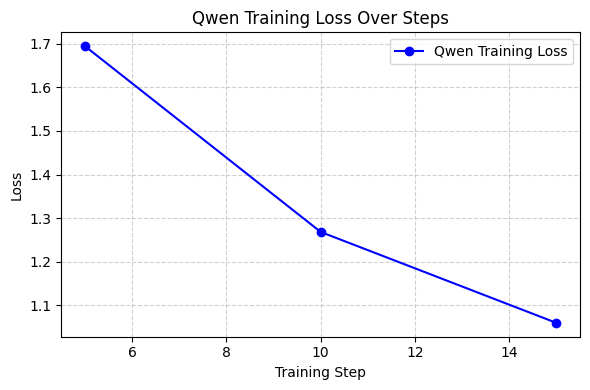

In [21]:
import matplotlib.pyplot as plt
import numpy as np

steps = [5, 10, 15]
losses = [1.6946, 1.2684, 1.0598]

plt.figure(figsize=(6, 4))
plt.plot(steps, losses, marker='o', color='blue', label='Qwen Training Loss')
plt.title("Qwen Training Loss Over Steps")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()



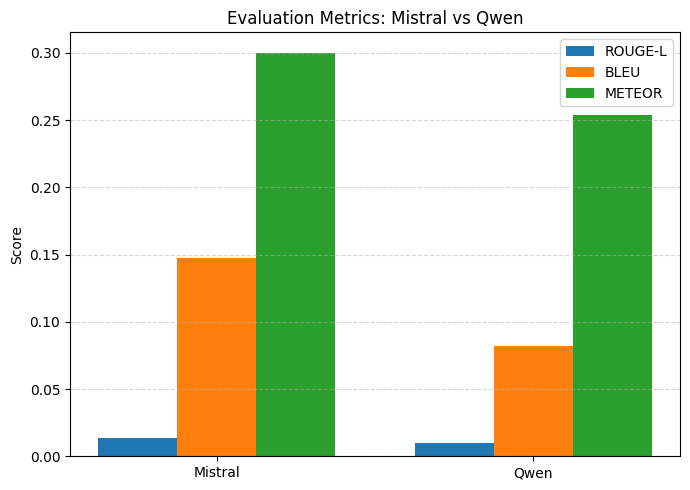

In [22]:

models = ["Mistral", "Qwen"]
rouge_l = [0.0133, 0.0100]
bleu = [0.1475, 0.0819]
meteor = [0.3002, 0.2535]

x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(7, 5))
plt.bar(x - width, rouge_l, width, label='ROUGE-L')
plt.bar(x, bleu, width, label='BLEU')
plt.bar(x + width, meteor, width, label='METEOR')

plt.xticks(x, models)
plt.ylabel("Score")
plt.title("Evaluation Metrics: Mistral vs Qwen")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
